In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import json

import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# SQL Connection

In [4]:
# Read the MySQL configuration from the JSON file
with open('../config.json', 'r') as config_file:
    config = json.load(config_file)

In [5]:
# Extract MySQL connection details
mysql_config = config.get('mysql', {})
username = mysql_config.get('username', 'default_username')
password = mysql_config.get('password', 'default_password')
host = mysql_config.get('host', 'localhost')
database_name = mysql_config.get('database_name', 'your_database')

In [6]:
# Create the MySQL database connection string
db_url = f"mysql+mysqlconnector://{username}:{password}@{host}/{database_name}"

# Create an SQLAlchemy engine
engine = create_engine(db_url)

# Use the engine to connect to the database
connection = engine.connect()

In [7]:
# Specify the SQL query to retrieve data from a table
query = "SELECT * FROM joined_rewa"

# Use Pandas to read data from the database into a DataFrame
df = pd.read_sql(query, connection)

# Close the database connection
connection.close()

df.head()

,LeftTableTime,RightTableTime,WindForecast,GustForecast,TempForecast,PrecipitationForecast,CloudForecast,WindDirForecast,WindDirBinForecast,WindMeasured,GustMeasured,TempMeasured,WindDirMeasured,BaroMeasured,Month
0,2021-01-26 00:00:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,9.91,11.27,1.2,236.0,1027.5,1
1,2021-01-26 00:10:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,10.69,12.63,1.2,234.0,1027.6,1
2,2021-01-26 00:20:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,9.91,11.27,1.3,261.0,1027.5,1
3,2021-01-26 00:30:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,10.11,11.86,1.1,242.0,1027.4,1
4,2021-01-26 00:40:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,10.89,11.86,1.1,244.0,1027.5,1


# Feature Engineering

In [8]:
df_avg = df.groupby('RightTableTime')[['WindMeasured', 'WindForecast', 'WindDirForecast', 'Month', 'CloudForecast','GustForecast','TempForecast','PrecipitationForecast', 'WindDirMeasured']].mean().reset_index().dropna()
df_avg.head()

,RightTableTime,WindMeasured,WindForecast,WindDirForecast,Month,CloudForecast,GustForecast,TempForecast,PrecipitationForecast,WindDirMeasured
0,2021-01-26 02:00:00,10.594167,12.0,287.0,1.0,100.0,16.0,2.0,0.0,246.500000
1,2021-01-26 04:00:00,11.809167,9.0,280.0,1.0,100.0,15.0,1.0,0.0,264.916667
2,2021-01-26 06:00:00,11.273333,11.0,272.0,1.0,100.0,17.0,1.0,0.0,265.583333
3,2021-01-26 08:00:00,9.377500,10.0,283.0,1.0,100.0,15.0,1.0,0.1,253.666667
4,2021-01-26 10:00:00,9.540833,8.0,295.0,1.0,92.0,14.0,1.0,0.1,265.166667


In [9]:
# Calculate delta
df_avg['delta'] = df_avg['WindMeasured'] - df_avg['WindForecast']
df_avg.head()

,RightTableTime,WindMeasured,WindForecast,WindDirForecast,Month,CloudForecast,GustForecast,TempForecast,PrecipitationForecast,WindDirMeasured,delta
0,2021-01-26 02:00:00,10.594167,12.0,287.0,1.0,100.0,16.0,2.0,0.0,246.500000,-1.405833
1,2021-01-26 04:00:00,11.809167,9.0,280.0,1.0,100.0,15.0,1.0,0.0,264.916667,2.809167
2,2021-01-26 06:00:00,11.273333,11.0,272.0,1.0,100.0,17.0,1.0,0.0,265.583333,0.273333
3,2021-01-26 08:00:00,9.377500,10.0,283.0,1.0,100.0,15.0,1.0,0.1,253.666667,-0.622500
4,2021-01-26 10:00:00,9.540833,8.0,295.0,1.0,92.0,14.0,1.0,0.1,265.166667,1.540833


In [10]:
# Add hour column - temporary
df_avg['Hour'] = df_avg['RightTableTime'].dt.hour

In [11]:
# Assuming 'df' is your DataFrame with wind data
# You can define your bins and labels for wind speed
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26,28,30,np.inf]  # Customize bin edges as needed
labels = ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-24','24-26', '26-28', '28-30', '30+']

# Create a new column 'WindSpeedBin' with the binned wind speeds
df_avg['WindMeasuredBin'] = pd.cut(df_avg['WindMeasured'], bins=bins, labels=labels)
df_avg['WindForecastBin'] = pd.cut(df_avg['WindForecast'], bins=bins, labels=labels)

# Define wind direction bins
bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

# Bin wind directions and calculate mean wind speed for each bin
df_avg['WindDirMeasuredBin'] = pd.cut(df_avg['WindDirMeasured'], bins=bins, labels=labels)
df_avg['WindDirBinForecast'] = pd.cut(df_avg['WindDirForecast'], bins=bins, labels=labels)
#aggregated_data = df_avg.groupby('WindDirBin')['WindSpeed'].count().reset_index()
aggregated_data_measured = df_avg.groupby(['WindDirMeasuredBin', 'WindMeasuredBin']).agg({'WindMeasured':'mean', 'delta':'mean','WindDirMeasured':'count'}).reset_index()
aggregated_data_forecast = df_avg.groupby(['WindDirBinForecast', 'WindForecastBin']).agg({'WindForecast':'mean', 'delta':'mean','WindDirForecast':'count'}).reset_index()

In [12]:
aggregated_data_measured['FrequencyMeasured'] = np.round(aggregated_data_measured['WindDirMeasured']/aggregated_data_measured['WindDirMeasured'].sum(),5)*100
aggregated_data_forecast['FrequencyForecast'] = np.round(aggregated_data_forecast['WindDirForecast']/aggregated_data_forecast['WindDirForecast'].sum(),5)*100

# Vizualizations

In [13]:
# Create a wind rose plot
fig = px.bar_polar(aggregated_data_measured, r='FrequencyMeasured', theta='WindDirMeasuredBin', color='WindMeasured',
                   template='plotly_dark', color_discrete_sequence=px.colors.sequential.Plasma_r)
# Set the figure size
fig.update_layout(width=1600, height=800)
fig.show()

In [14]:
# Create a wind rose plot
fig = px.bar_polar(aggregated_data_forecast, r='FrequencyForecast', theta='WindDirBinForecast', color='WindForecast',
                   template='plotly_dark', color_discrete_sequence=px.colors.sequential.Plasma_r)
# Set the figure size
fig.update_layout(width=1600, height=800)
fig.show()

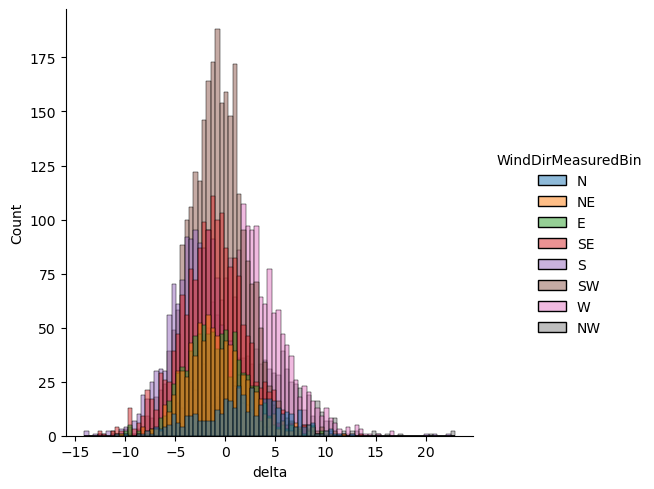

In [15]:
df_avg['Month'].astype('category')
sns.displot(data=df_avg, x='delta', hue='WindDirMeasuredBin', kind='hist')

# Forecast Accuracy

In [16]:
forecast = df_avg['WindForecast']
measurments = df_avg['WindMeasured']

mae = mean_absolute_error(measurments, forecast)
mse = mean_squared_error(measurments, forecast)
r2 = r2_score(measurments, forecast)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Absolute Error: 2.99
Mean Squared Error: 14.64
R-squared (R2) Score: 0.63


# Random Forest

In [17]:
# Features and labels split
X = df_avg[['WindForecast', 'WindDirForecast', 'Month', 'GustForecast', 'Hour']]
y = df_avg['WindMeasured']

In [18]:
# Train Valid Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Fit
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Display feature importance
feature_importances = clf.feature_importances_

feature_importances = dict(zip(X.columns,feature_importances))
feature_importances

{'WindForecast': 0.6659935389864914,
 'WindDirForecast': 0.18426975667631976,
 'Month': 0.05093627997329472,
 'GustForecast': 0.051925703172536336,
 'Hour': 0.04687472119135774}

In [20]:
# Predict on the validation set
y_pred = clf.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Absolute Error: 2.17
Mean Squared Error: 8.68
R-squared (R2) Score: 0.78


# XGBOOST

In [21]:
# Create an XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)

# Fit the model to the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
# Predict on the validation set
y_pred = model.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Absolute Error: 2.16
Mean Squared Error: 8.56
R-squared (R2) Score: 0.78


# Forecast

In [23]:
df_forecast = pd.read_csv('data_collection_notebooks/forecast.csv')
df_forecast.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data_collection_notebooks/forecast.csv'

In [ ]:
X_forecast = df_forecast[['WindForecast', 'WindDirForecast', 'Month', 'GustForecast', 'Hour']]

In [ ]:
y_pred = model.predict(X_forecast)
df_forecast['windspeed_10m_ml'] = y_pred
df_forecast.to_csv('forecast_improved.csv')

# Test Forecast

In [ ]:
# Create the MySQL database connection string
db_url = f"mysql+mysqlconnector://{username}:{password}@{host}/{database_name}"

# Create an SQLAlchemy engine
engine = create_engine(db_url)

# Use the engine to connect to the database
connection = engine.connect()

In [ ]:
# Specify the SQL query to retrieve data from a table
query = "SELECT * FROM measurments_rewa WHERE DATE(Time) = '2023-10-07'"

# Use Pandas to read data from the database into a DataFrame
df_test = pd.read_sql(query, connection)

# Close the database connection
connection.close()

df_test

,Time,WindSpeed,WindGust,Temp,WindDir,Baro
0,2023-10-07 00:00:00,10.50,19.24,15.2,210.0,1002.9
1,2023-10-07 00:10:00,11.86,19.83,15.2,182.0,1003.1
2,2023-10-07 00:20:00,9.91,17.88,15.3,201.0,1003.0
3,2023-10-07 00:30:00,6.61,19.24,15.2,196.0,1002.8
4,2023-10-07 00:40:00,11.27,17.88,15.3,197.0,1002.5
...,...,...,...,...,...,...
89,2023-10-07 14:50:00,21.19,29.16,13.3,293.0,1007.2
90,2023-10-07 15:00:00,21.19,27.02,13.2,294.0,1007.2
91,2023-10-07 15:10:00,20.41,25.08,13.1,294.0,1007.4
92,2023-10-07 15:20:00,17.88,25.08,13.1,294.0,1007.3


In [ ]:
# Convert the 'Time' column to datetime
df_test['Time'] = pd.to_datetime(df_test['Time'])

# Set the 'Time' column as the index
df_test.set_index('Time', inplace=True)

# Resample the data with a two-hour interval and apply mean aggregation
df_test = df_test.resample('2H').mean()


y_test = df_test['WindSpeed']
y_test

Time
2023-10-07 00:00:00    11.922500
2023-10-07 02:00:00    19.520833
2023-10-07 04:00:00    24.816667
2023-10-07 06:00:00    27.520833
2023-10-07 08:00:00    24.751667
2023-10-07 10:00:00    25.625833
2023-10-07 12:00:00    23.423333
2023-10-07 14:00:00    20.819000
Freq: 2H, Name: WindSpeed, dtype: float64

In [ ]:
df_forecast = df_forecast[(df_forecast['Time'] > '2023-10-07') & (df_forecast['Time'] < '2023-10-07 15:00:00')]

# Convert the 'Time' column to datetime
df_forecast['Time'] = pd.to_datetime(df_forecast['Time'])

# Set the 'Time' column as the index
df_forecast.set_index('Time', inplace=True)

# Resample the data with a two-hour interval and apply mean aggregation
df_forecast = df_forecast.resample('2H').mean()

In [ ]:
y_pred = df_forecast['windspeed_10m_ml']
y_forecast = df_forecast['WindForecast']

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Model Accuracy')
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Model Accuracy
Mean Absolute Error: 7.83
Mean Squared Error: 74.99
R-squared (R2) Score: -2.54


In [ ]:
df = pd.DataFrame()
df['Pred'] = y_pred
df['Measured'] = y_test
df['Forecast'] = y_forecast
df

,Pred,Measured,Forecast
Time,,,
2023-10-07 00:00:00,22.054754,11.922500,24.55
2023-10-07 02:00:00,31.503927,19.520833,29.20
2023-10-07 04:00:00,37.746452,24.816667,32.50
2023-10-07 06:00:00,36.752907,27.520833,31.20
2023-10-07 08:00:00,32.517342,24.751667,27.20
2023-10-07 10:00:00,28.463724,25.625833,24.30
2023-10-07 12:00:00,26.146008,23.423333,22.00
2023-10-07 14:00:00,25.867332,20.819000,20.60


In [ ]:
mae = mean_absolute_error(y_test, y_forecast)
mse = mean_squared_error(y_test, y_forecast)
r2 = r2_score(y_test, y_forecast)

print('GFS 13km Accuracy')
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

GFS 13km Accuracy
Mean Absolute Error: 4.89
Mean Squared Error: 41.94
R-squared (R2) Score: -0.98


# Replace forecast historical forecast location

In [31]:
# Create the MySQL database connection string
db_url = f"mysql+mysqlconnector://{username}:{password}@{host}/{database_name}"

# Create an SQLAlchemy engine
engine = create_engine(db_url)

# Use the engine to connect to the database
connection = engine.connect()

In [32]:
# Specify the SQL query to retrieve data from a table
query = "SELECT * FROM historical_forecast"

# Use Pandas to read data from the database into a DataFrame
df = pd.read_sql(query, connection)

# Close the database connection
connection.close()

df

,Wind,Wind_Gust,Temperature,Precipitation,Cloud_Cover,Datetime,Wind_Direction,Month,WindDirBin
0,7.0,12.0,2.0,0.0,97.0,2021-01-01 02:00:00,191.0,1,S
1,7.0,11.0,2.0,0.0,26.0,2021-01-01 04:00:00,184.0,1,S
2,8.0,12.0,2.0,0.0,100.0,2021-01-01 06:00:00,171.0,1,SE
3,9.0,13.0,2.0,0.0,100.0,2021-01-01 08:00:00,166.0,1,SE
4,9.0,14.0,2.0,0.0,100.0,2021-01-01 10:00:00,164.0,1,SE
...,...,...,...,...,...,...,...,...,...
12019,7.0,15.0,19.0,0.0,100.0,2023-10-02 16:00:00,234.0,10,SW
12020,8.0,17.0,19.0,0.2,100.0,2023-10-02 18:00:00,229.0,10,SW
12021,8.0,18.0,18.0,0.0,100.0,2023-10-02 20:00:00,232.0,10,SW
12022,8.0,19.0,18.0,0.0,100.0,2023-10-02 22:00:00,223.0,10,S


In [33]:
df['Hour'] = df['Datetime'].dt.hour

In [37]:
df_new = pd.DataFrame()

In [38]:
df_new[['Time','Month','Hour','WindForecast','GustForecast','WindDirForecast','Temperature','Precipitation','Cloudcover']] = \
df[['Datetime','Month','Hour','Wind','Wind_Gust','Wind_Direction','Temperature','Precipitation','Cloud_Cover']]

In [39]:
df_new

,Time,Month,Hour,WindForecast,GustForecast,WindDirForecast,Temperature,Precipitation,Cloudcover
0,2021-01-01 02:00:00,1,2,7.0,12.0,191.0,2.0,0.0,97.0
1,2021-01-01 04:00:00,1,4,7.0,11.0,184.0,2.0,0.0,26.0
2,2021-01-01 06:00:00,1,6,8.0,12.0,171.0,2.0,0.0,100.0
3,2021-01-01 08:00:00,1,8,9.0,13.0,166.0,2.0,0.0,100.0
4,2021-01-01 10:00:00,1,10,9.0,14.0,164.0,2.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...
12019,2023-10-02 16:00:00,10,16,7.0,15.0,234.0,19.0,0.0,100.0
12020,2023-10-02 18:00:00,10,18,8.0,17.0,229.0,19.0,0.2,100.0
12021,2023-10-02 20:00:00,10,20,8.0,18.0,232.0,18.0,0.0,100.0
12022,2023-10-02 22:00:00,10,22,8.0,19.0,223.0,18.0,0.0,100.0


In [41]:
df_new.to_sql('forecast_rewa', engine, if_exists='replace', index=False)

12024